In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [138]:
fifa21 = pd.read_csv('../input/fifa-21-complete-player-dataset/fifa21_male2.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.



# Data Preprocessing

## Data Cleaning

In [139]:
missing = pd.DataFrame()
missing['column'] = fifa21.columns

missing['percent'] = [
    round(100* fifa21[col].isnull().sum() / len(fifa21), 2) for col in fifa21.columns
]
missing = missing[missing['percent']>0].sort_values('percent')

fig = px.bar(
    missing, 
    x='percent',
    y="column", 
    orientation='h', 
    title='Percent of Missing Values in each Column', 
    height=1300, 
    width=800
)
fig.show()


### Dropping problematic columns

In [140]:
fifa21.drop(['Loan Date End','Joined','Hits','Gender'],axis=1,inplace=True)

In [141]:
fifa21.head()

,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,...,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,...,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,...,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,...,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,...,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3


### Looks like we have Object Types...

In [142]:
print(fifa21.Value.dtype)
print(fifa21.Wage.dtype)
print(fifa21['Release Clause'].dtype)
print(fifa21.Height.dtype)
print(fifa21.Weight.dtype)

object
object
object
object
object


### We must omit the Euro symbol and multiply the number in the object by either 1000 for 'K' or 1000000 for 'M'
### Height and Weight will be formatted as well

In [143]:
fifa21.Value.head(),fifa21.Wage.head(),fifa21['Release Clause'].head()

(0    €625K
 1    €600K
 2    €1.1M
 3       €0
 4    €5.5M
 Name: Value, dtype: object,
 0     €7K
 1     €7K
 2    €15K
 3      €0
 4    €12K
 Name: Wage, dtype: object,
 0       €0
 1    €1.1M
 2       €0
 3       €0
 4    €7.2M
 Name: Release Clause, dtype: object)

In [144]:
fifa21['Weight'].head(),fifa21['Height'].head()

(0    181lbs
 1    143lbs
 2    161lbs
 3    165lbs
 4    150lbs
 Name: Weight, dtype: object,
 0     6'0"
 1    5'10"
 2     5'9"
 3    5'11"
 4     5'7"
 Name: Height, dtype: object)

## Formatting Object Types

In [145]:
#formating the Value column
def format_money(column):
    values = []
    for value in fifa21[column]:
        if value[-1]=='M':
            money = 1000000
            money *= float(value[1:-1])
        elif value[-1]=='K':
            money = 1000
            money *= float(value[1:-1])
        else: 
            money = 0
        values.append(money)
    return values

# formating Weight column
def format_weight():
    weights = []
    for weight in fifa21['Weight'].fillna(''):
        if weight != '':
            weights.append(int(weight[:-3]))
        else:
            weights.append(np.nan)
    return weights

# formating Height Column
def format_height():
    heights = []
    for height in fifa21['Height'].fillna(''):
        if height != '':
            height =int(height[0])*12 + int(height[2])
            heights.append(height)
        else:
            heights.append(np.nan)
    return heights

# # formating Release Clause

def format_release_clause():
    release_clause = []
    for clause in fifa21['Release Clause'].fillna(''):
        if clause == '':
            money=0.0
        elif clause[-1]=='M':
            money = 1000000
            money *= float(clause[1:-1])
        elif clause[-1]=='K':
            money = 1000
            money *= float(clause[1:-1])
        else: 
            money = 0
        release_clause.append(money)
    return release_clause

In [146]:
fifa21['Value'] =  format_money('Value')
fifa21['Wage'] = format_money('Wage')
fifa21['Weight'] = format_weight()
fifa21['Height'] = format_height()
fifa21['Release Clause'] = format_release_clause()

### Looks like we have 0s inplace for some 'Wage' and 'Value' obs. I cross validated this with sofifa.com, and it turns out the website just doesn't yet have data on those players. Essentially, every '0' inplace for Value overlaps with that of Wage, so we can drop observations relative to Wage = 0, but the following is another way to drop them via the use of numpy

In [147]:
(fifa21).describe()

,ID,Age,OVA,BOV,POT,Height,Weight,Growth,Value,Wage,...,GK Positioning,GK Reflexes,Total Stats,Base Stats,PAC,SHO,PAS,DRI,DEF,PHY
count,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,1.712500e+04,17125.000000,...,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000,17125.000000
mean,219388.716204,25.272934,66.965022,67.900204,72.489810,68.941664,165.658861,5.524788,2.567377e+06,10436.963504,...,15.514277,15.738628,1631.256175,361.372146,68.091620,54.967299,58.926540,64.209869,50.266102,64.910715
std,37499.197507,4.942665,6.864329,6.637538,5.769949,5.344764,15.818185,5.787539,5.372622e+06,21191.481943,...,16.406064,17.130908,260.357024,40.252290,11.147116,13.877605,10.186728,9.832734,16.853801,9.660260
min,2.000000,16.000000,38.000000,42.000000,47.000000,61.000000,110.000000,-1.000000,0.000000e+00,0.000000,...,1.000000,1.000000,731.000000,228.000000,25.000000,16.000000,25.000000,28.000000,12.000000,27.000000
25%,204082.000000,21.000000,62.000000,64.000000,69.000000,61.000000,154.000000,0.000000,3.750000e+05,1000.000000,...,8.000000,8.000000,1492.000000,333.000000,62.000000,46.000000,52.000000,59.000000,35.000000,59.000000
50%,228961.000000,25.000000,67.000000,68.000000,72.000000,69.000000,165.000000,4.000000,8.000000e+05,3000.000000,...,11.000000,11.000000,1659.000000,362.000000,69.000000,58.000000,60.000000,65.000000,53.000000,66.000000
75%,243911.000000,29.000000,72.000000,72.000000,76.000000,73.000000,176.000000,9.000000,2.400000e+06,11000.000000,...,14.000000,14.000000,1812.000000,390.000000,75.000000,65.000000,66.000000,71.000000,64.000000,72.000000
max,259105.000000,53.000000,93.000000,93.000000,95.000000,81.000000,243.000000,26.000000,1.055000e+08,560000.000000,...,93.000000,90.000000,2316.000000,498.000000,96.000000,93.000000,93.000000,95.000000,91.000000,93.000000


### Removing zeroes in wage,release clause, and value columns

In [148]:
dropdex = (fifa21.loc[fifa21.Value==0].index)
dropdex = dropdex.append((fifa21.loc[fifa21.Wage==0].index))
dropdex = dropdex.append((fifa21.loc[fifa21['Release Clause']==0].index))
dropdex = np.unique(dropdex)

In [149]:
fifa21 = fifa21.drop(index=dropdex, axis = 1)

In [150]:
print(sum(fifa21.Value==0),sum(fifa21.Wage==0),sum(fifa21['Release Clause']==0))

0 0 0


In [151]:
fifa21.shape

(12691, 103)

### We lost ~4500 observations in the cleaning process... It's okay, though - our data is still just as comprehensive

# Feature Engineering

## General Position 

#### In FIFA, there are 24 different positions... Our goal here is to create a new variable in the data connotating players' general positions.

#### The Four General Positions are:
- Forward
- Midfielder
- Defender
- Goalkeeper

In [152]:
conditions = [
    (fifa21['BP'] == 'RF') | (fifa21['BP'] == 'ST') | (fifa21['BP'] == 'LW') | (fifa21['BP'] == 'LF') | (fifa21['BP'] == 'RS') | (fifa21['BP'] == 'LS') | (fifa21['BP'] == 'RW') | (fifa21['BP'] == 'CF')
    ,(fifa21['BP'] == 'RCM') | (fifa21['BP'] == 'LCM') | (fifa21['BP'] == 'LDM') | (fifa21['BP'] == 'CAM') | (fifa21['BP'] == 'CDM') | (fifa21['BP'] == 'RM') | (fifa21['BP'] == 'LAM') | (fifa21['BP'] == 'LM') | (fifa21['BP'] == 'RDM') | (fifa21['BP'] == 'CM') | (fifa21['BP'] == 'RAM')
    ,(fifa21['BP'] == 'RCB') | (fifa21['BP'] == 'CB') | (fifa21['BP'] == 'LCB') | (fifa21['BP'] == 'LB') | (fifa21['BP'] == 'RB') | (fifa21['BP'] == 'LWB') | (fifa21['BP'] == 'RWB')
    ,(fifa21['BP'] == 'GK')]

choices = ['FW','MID','DEF',"GK"]
fifa21['GPOS'] = np.select(conditions, choices, default='N/A')
fifa21['GPOS']

1        MID
4        MID
6        MID
26        GK
41        GK
        ... 
17119     GK
17121    MID
17122    DEF
17123    DEF
17124     FW
Name: GPOS, Length: 12691, dtype: object

 ## Encoding GPOS

In [155]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'GPOS'. 
fifa21['GPOS']= label_encoder.fit_transform(fifa21['GPOS']) 
  
fifa21['GPOS'].unique()

array([3, 2, 0, 1])

In [22]:
#Inverse the encoding
label_encoder.inverse_transform(fifa21.GPOS)

array(['MID', 'MID', 'MID', ..., 'DEF', 'DEF', 'FW'], dtype=object)

## BMI
### Since we have player Height and Weight, why not calculate their BMI? Perhaps it can be a helpful variable in the future...

In [153]:
import math

In [154]:
fifa21['BMI'] = fifa21.Weight*0.453592/pow((fifa21.Height*2.54)/100,2)

# Modeling

## Feature Selection

In [67]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [68]:
df = fifa21.copy()

In [69]:
categorical = [
    'Nationality', 
    'Club', 
    'foot',
    'A/W',
    'D/W',
    'W/F',
    'BP',
    'SM',
    'IR'
]

In [70]:
for item in categorical:
    df[item] = df[item].fillna('0') 
    le = preprocessing.LabelEncoder()
    df[item] = le.fit_transform(df[item])

In [71]:
drop = [
    'ID', 'Name', 'Player Photo' 
     ,'POT', 'Club Logo', 'Flag Photo' 
      ,'Team & Contract','Contract' , 'Position', 'BOV'
    
    ,'Release Clause'
    ,'Wage' 
    #,'Growth'
    ,'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF' 
    ,'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM' 
    ,'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB','GK'
    
    #,'PAC' 
    ,'SHO', 'PAS', 'DRI', 'DEF', 'PHY'
    , 'Total Stats','Base Stats' 
    ,'Skill'
    ,'GPOS'
    , 'BMI'
,'Nationality'
,'Club'
,'BP'
,'Height'
,'Weight'
,'foot'
,'Balance'
,'Jumping'
,'Strength'
,'Interceptions'
,'Defending'
,'Marking'
,'Standing Tackle'
,'Sliding Tackle'
,'Goalkeeping'
,'GK Diving'
,'GK Handling'
,'GK Kicking'
,'GK Positioning'
,'GK Reflexes'
,'W/F'
,'A/W'
,'D/W'
]

df = df.drop(drop, axis=1)

# PCA & Clustering

In [76]:
fifacluster=fifa21[["Attacking","Crossing","Finishing"
,"Heading Accuracy","Short Passing","Volleys"
,"Skill","Dribbling","Curve"
,"FK Accuracy","Long Passing","Ball Control"
,"Movement","Acceleration","Sprint Speed"
,"Agility","Reactions","Balance"
,"Power","Shot Power","Jumping"
,"Stamina","Strength","Long Shots"
,"Mentality","Aggression","Interceptions"
,"Positioning","Vision","Penalties"
,"Composure","Defending","Marking"
,"Standing Tackle","Sliding Tackle","Goalkeeping"
,"GK Diving","GK Handling","GK Kicking"
,"GK Positioning","GK Reflexes","GPOS"]]
fifacluster.head()

,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,...,Marking,Standing Tackle,Sliding Tackle,Goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,GPOS
1,337,68,64,61,76,68.0,369,69,79.0,79,...,70,43,40.0,56,9,12,13,11,11,3
4,367,75,69,54,90,79.0,408,85,80.0,70,...,68,57,56.0,45,6,13,6,13,7,3
6,342,80,66,43,84,69.0,406,77,83.0,80,...,65,65,60.0,47,7,11,7,14,8,3
26,95,13,15,13,37,17.0,122,26,20.0,13,...,13,11,11.0,396,77,76,74,91,78,2
41,93,18,11,14,39,11.0,106,12,13.0,13,...,9,15,14.0,355,69,71,72,73,70,2


In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(fifacluster[fifacluster.columns[~fifacluster.columns.isin(['GPOS'])]])

In [78]:
# Creating a dataframe featuring the two Principal components that we acquired through PCA.
PCA_dataset1 = pd.DataFrame(data = principalComponents1, columns = ['component1', 'component2'] )
PCA_dataset1.head()

,component1,component2
0,-138.833440,17.891385
1,-194.918146,19.972204
2,-188.461800,-7.079458
3,452.539890,69.273177
4,465.567062,32.104863


In [79]:
principal_component1 = PCA_dataset1['component1']
principal_component2 = PCA_dataset1['component2']

<Figure size 576x396 with 0 Axes>

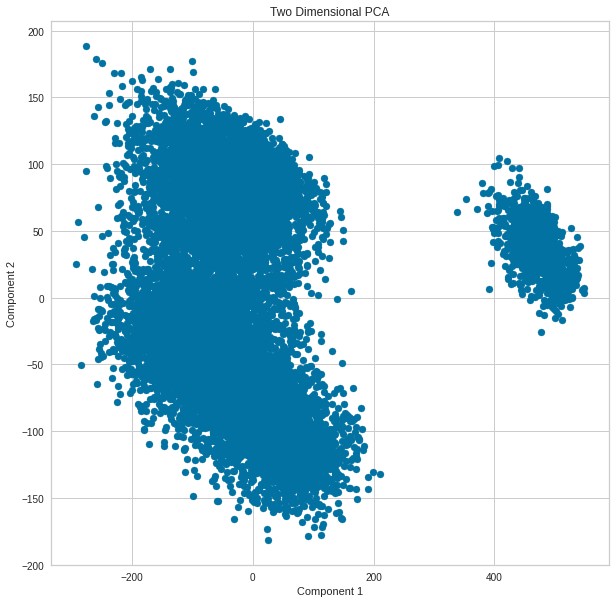

In [106]:
# Visualizing PCA in 2 Dimensions.
plt.figure()
plt.figure(figsize=(10,10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Two Dimensional PCA')
plt.scatter(PCA_dataset1['component1'], PCA_dataset1['component2']
            #, c = y_kmeans, s=10
           )
plt.show()

#### Intrestingly, we see a large peice of scatter (to the left) which looks made up of 2 seperate clusters and a smaller, distant piece of scatter (to the right)
#### It would be interesting to see how these attributes cluster...

### How many Clusters do we need?

In [81]:
from yellowbrick.cluster import KElbowVisualizer

In [82]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
y_kmeans = kmeans.fit_predict(principalComponents1)

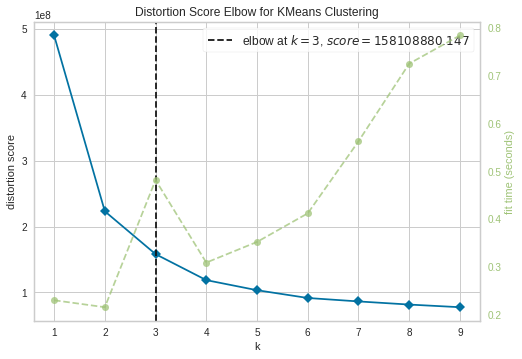

In [83]:
model = KMeans()
fig = KElbowVisualizer(model,k=(1,10))
fig.fit(fifacluster[fifacluster.columns[~fifacluster.columns.isin(['GPOS','BMI','eGPOS'])]])
fig.show();

In [87]:
fifacluster['principal component 1'] = principal_component1
fifacluster['principal component 2'] = principal_component2
fifacluster['cluster'] = y_kmeans

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## Visualizaing Clusters

In [88]:
from matplotlib import colors as mcolors

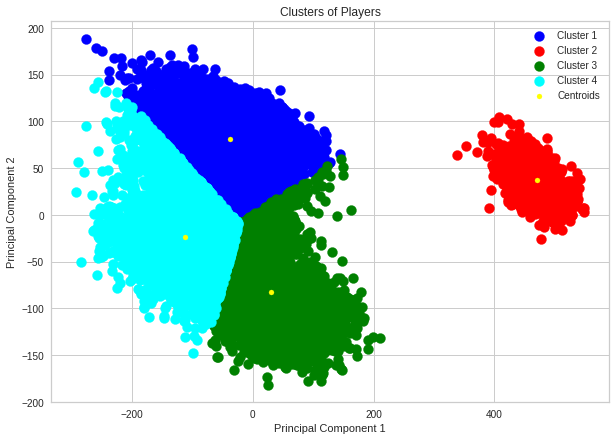

In [89]:
plt.figure(figsize=(10,7))
plt.scatter(principalComponents1[y_kmeans == 0, 0], principalComponents1[y_kmeans == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(principalComponents1[y_kmeans == 1, 0], principalComponents1[y_kmeans == 1, 1], s = 100, c = 'red', label = 'Cluster 2')
plt.scatter(principalComponents1[y_kmeans == 2, 0], principalComponents1[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(principalComponents1[y_kmeans == 3, 0], principalComponents1[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
#plt.scatter(principalComponents1[y_kmeans == 4, 0], principalComponents1[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
#plt.scatter(principalComponents1[y_kmeans == 5, 0], principalComponents1[y_kmeans == 5, 1], s = 100, c = 'limegreen', label = 'Cluster 6')
#plt.scatter(principalComponents1[y_kmeans == 6, 0], principalComponents1[y_kmeans == 6, 1], s = 100, c = 'silver', label = 'Cluster 7')
#plt.scatter(principalComponents1[y_kmeans == 7, 0], principalComponents1[y_kmeans == 7, 1], s = 100, c = 'rosybrown', label = 'Cluster 8')
#plt.scatter(principalComponents1[y_kmeans == 8, 0], principalComponents1[y_kmeans == 8, 1], s = 100, c = 'mediumpurple', label = 'Cluster 9')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 25, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Players')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

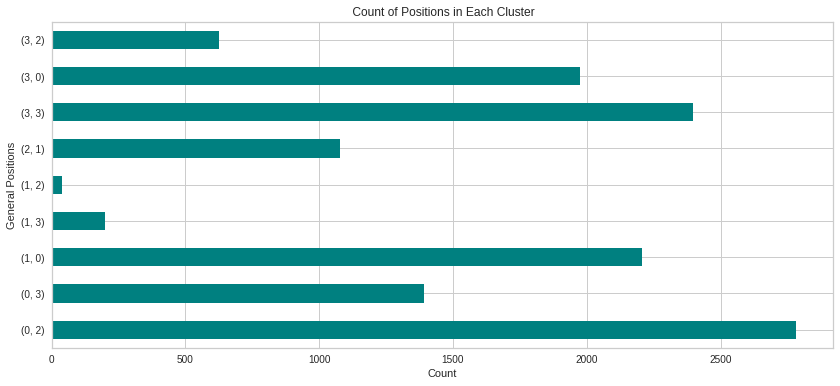

In [90]:
fifacluster.groupby("GPOS")["cluster"].value_counts().plot(kind="barh",color="teal",figsize=(14,6))
plt.ylabel('General Positions')
plt.xlabel('Count')
plt.title(' Count of Positions in Each Cluster')
plt.show()

In [91]:
pd.crosstab( index=fifacluster['cluster'],columns=fifacluster['GPOS'])

GPOS,0,1,2,3
cluster,,,,
0,0,2207,0,1975
1,0,0,1077,0
2,2781,39,0,627
3,1390,198,0,2397


### It seems as if our clusters form generally/mostly around each player position. Given the attributes fed to the model, and the discerning of the four clusters, we can confidently say that players along the borders of the three neighboring clusters are position-fluid - this means that we can potentially try to find 'well-rounded' players along that general area, and perhaps between the centroids of the three clusters.

### It would even make sense to continue to cluster to try to pinpoint these groups of players

# Normalizing 'Value'

In [93]:
target = np.log1p(df['Value'])
original_target = df['Value']
df = df.drop(['Value'], axis=1)

### 'Value' is un-normal, and is skewed to the right

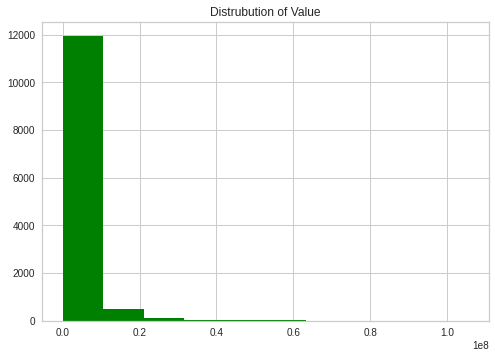

In [94]:
plt.hist(original_target,color='green')
plt.title('Distrubution of Value')
plt.show()

### However, 'Value' is log normal.

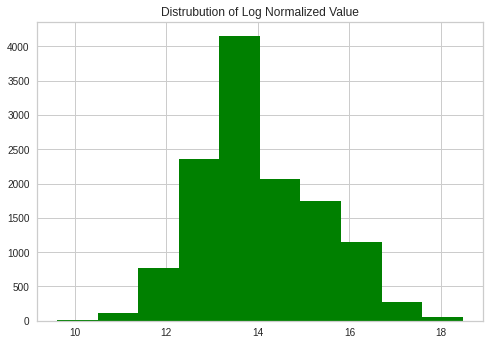

In [95]:
plt.hist(target,color='green')
plt.title('Distrubution of Log Normalized Value')
plt.show()

# Linear Regression

## Train/Test Split

In [96]:
scaler=MinMaxScaler()

X = df.copy()

y = target.copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=99,shuffle=True)

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [97]:
reg = LinearRegression()

reg.fit(X_train,y_train)

pred = reg.predict(X_train)

scores = cross_val_score(reg,X,y)
 
pred_1 = reg.predict(X_test)

respred=(np.expm1(pred_1))
restrue=(np.expm1(y_test))


#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
#Real value MAPE
LR_MAPE= MAPE(y_test,pred_1)

print('MAPE:', '{:0.3f}'.format(LR_MAPE)+'%')
print('Train r2 Score:','{:0.3f}'.format(reg.score(X_train, y_train)*100)+'%')
print('Test r2 Score:','{:0.3f}'.format(reg.score(X_test, y_test)*100))
print('Adjusted r2 Score:','{:0.3f}'.format((1-((1-reg.score(X_test, y_test)*100)*((4188-1))/(4188-35-1))))+'%')
#print('MSE:', mean_squared_error(y_true=restrue, y_pred=respred,squared=True))
print('RMSE:', mean_squared_error(restrue, respred,squared=False))
print('MAE:', mean_absolute_error(restrue, respred))

respred=np.array(np.expm1(pred_1)).reshape(-1,1)
restrue=np.array(np.expm1(y_test)).reshape(-1,1)
print('Cross Validation Score:','{:0.3f}'.format(cross_val_score(reg,restrue,respred,cv=2).mean()*100)+'%')

MAPE: 1.274%
Train r2 Score: 96.791%
Test r2 Score: 96.688
Adjusted r2 Score: 97.494%
RMSE: 3570337.0722695324
MAE: 716693.0674474067
Cross Validation Score: 91.488%


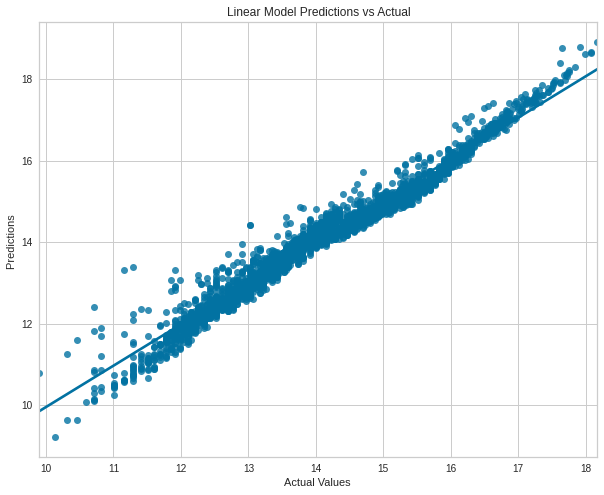

In [134]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=pred_1)
plt.xlabel('Actual Values ')
plt.ylabel('Predictions ')
plt.title('Linear Model Predictions vs Actual')
plt.show()

# Random Forest

In [156]:
random = RandomForestRegressor()

random.fit(X_train, y_train)

y_pred = random.predict(X_test)

In [158]:
RF_MAPE= MAPE((y_test),(y_pred))

y_pred1=np.array(np.expm1(y_pred)).reshape(-1,1)
y_test1=np.array(np.expm1(y_test)).reshape(-1,1)

cvs=cross_val_score(random,y_test1,y_pred1).mean()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 802, in check_X_y
    estimator=estimator)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.

In [102]:
print('Train r2 Score:',random.score(X_train, y_train))
print('Test r2 Score:',random.score(X_test, y_test))
print('Adjusted r2 Score:',(1-((1-random.score(X_test, y_test))*((4188-1))/(4188-35-1))))
#print('MSE:', mean_squared_error(y_true=y_test1, y_pred=y_pred1,squared=True))
print('RMSE:', mean_squared_error(y_true=y_test1, y_pred=y_pred1,squared=False))
print('MAE:', mean_absolute_error(y_test1, y_pred1))
print('MAPE:', RF_MAPE)
print('Cross Validation Score:',cvs)

Train r2 Score: 0.9993443991259662
Test r2 Score: 0.9886384384378379
Adjusted r2 Score: 0.9885426641953823
RMSE: 1002765.5425986581
MAE: 270827.26877005695
MAPE: 0.6114976168485916
Cross Validation Score: 0.9770573695917752


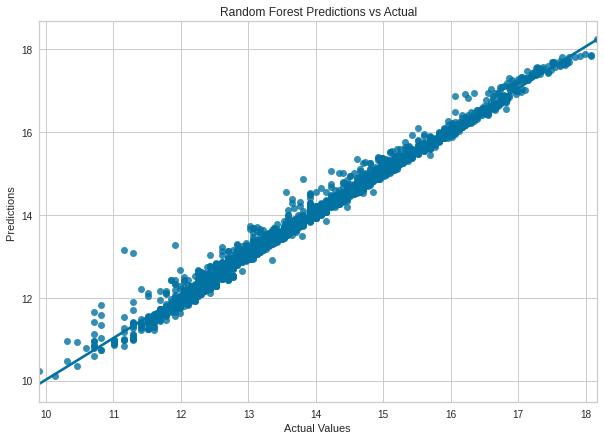

In [133]:
plt.figure(figsize=(10,7))

sns.regplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values ')
plt.ylabel('Predictions ')
plt.title('Random Forest Predictions vs Actual')
plt.show()


# Feature Importance

In [104]:
importances = random.feature_importances_
importances

array([7.34760986e-02, 9.02936280e-01, 1.32506185e-02, 4.91045722e-04,
       1.60259303e-04, 1.61512283e-03, 2.35995649e-04, 1.95506447e-04,
       7.10367340e-04, 4.34793972e-04, 2.20974731e-04, 2.02936366e-04,
       1.94802046e-04, 5.12892700e-04, 1.67108642e-04, 1.72214163e-04,
       1.91184683e-04, 1.92571499e-04, 2.85384020e-04, 3.99368839e-04,
       7.09128013e-04, 2.41865689e-04, 3.76180532e-04, 2.01180693e-04,
       2.43279614e-04, 7.56160202e-04, 3.38347148e-04, 4.98716174e-04,
       2.78378987e-04, 4.75180519e-05, 3.85981355e-05, 2.25120243e-04])

In [105]:
features = df.columns
imp = pd.DataFrame({'Features': features, 'Importance': importances})
imp.sort_values(by='Importance',ascending=False)

,Features,Importance
1,OVA,0.902936
0,Age,0.073476
2,Growth,0.013251
5,Finishing,0.001615
25,Positioning,0.000756
8,Volleys,0.000710
20,Shot Power,0.000709
13,Ball Control,0.000513
27,Penalties,0.000499
3,Attacking,0.000491
